In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf

import os
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv('/content/drive/My Drive/FutureTech.csv', parse_dates=['datetime'])
yval = df['RPM'] == 0
df['yval'] = yval
df = df[df['machineID']!=4]
length = len(df)

In [ ]:
df.head(90000)

,datetime,machineID,Voltage,RPM,pressure,vibration,yval
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,False
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,False
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,False
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,False
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,False
...,...,...,...,...,...,...,...
43800,2016-01-01 02:00:00,5,162.964887,511.046527,153.187090,41.772148,False
43801,2016-01-01 03:00:00,5,136.402165,402.228972,152.191926,38.078241,False
43802,2016-01-01 04:00:00,5,181.426439,460.280665,142.451849,44.551477,False
43803,2016-01-01 05:00:00,5,178.261658,424.821800,156.228631,39.976910,False


In [ ]:
def cal_hrs(length, yval):
  hoursto = np.zeros(length)
  hourssince = np.zeros(length)
  l = len(yval)
  temp1 = None
  temp2 = None
  for i in range(length-1, -1, -1):
    if yval[i] == 1:
      temp1 = 1
      hoursto[(i)] = 0
      continue
    if temp1 == 1:
      hoursto[(i)] = hoursto[(i)+1] + 1
    else:
      hoursto[(i)] = None
    if yval[length-1-(i)] == 1:
      temp2 = 1
      hourssince[length-1-(i)] = 0
      continue
    if temp2 == 1:
      hourssince[length-1-(i)] = hourssince[length-1-(i)-1] + 1
    else:
      hourssince[length-1-(i)] = None
  return hoursto, hourssince

In [ ]:
since = np.zeros(0)
to = np.zeros(0)

for mid in df.machineID.unique():
  l = len(df[df.machineID == mid])
  yval = df.yval[df.machineID == mid].values

  hrsince = np.zeros(l)
  hrsto = np.zeros(l)

  temp1 = -1
  temp2 = -1
  
  for i in range(0, l):
    if yval[i] == 1:
      temp1 = 1
      hrsince[i] == 0
    elif temp1 == 1:
      hrsince[i] = hrsince[i-1] + 1

    if yval[l-i-1] == 1:
      temp2 = 1
      hrsto[l-i-1] = 0
    elif temp2 == 1:
      hrsto[l-i-1] = hrsto[l-i] + 1

  temp1 = -1
  temp2 = -1

  for i in range(0, l):
    if hrsto[i] == 0 and hrsto[i-1] == 0:
      temp2 = 1
      hrsto[i] = 720
    elif temp2 == 1:
      hrsto[i] = hrsto[i-1] - 1
    
    if hrsince[l-i-1] == 0 and hrsince[l-i] == 0:
      temp1 = 1
      hrsince[l-i-1] = 720
    elif temp1 == 1:
      hrsince[l-i-1] = hrsince[l-i] - 1

  since = np.append(since, hrsince)
  to = np.append(to, hrsto)

df['hourssince'] = since
df['hoursto'] = to

In [ ]:
print(df)

                 datetime  machineID     Voltage  ...   yval  hourssince  hoursto
0     2015-01-01 06:00:00          1  176.217853  ...  False       642.0     79.0
1     2015-01-01 07:00:00          1  162.879223  ...  False       643.0     78.0
2     2015-01-01 08:00:00          1  170.989902  ...  False       644.0     77.0
3     2015-01-01 09:00:00          1  162.462833  ...  False       645.0     76.0
4     2015-01-01 10:00:00          1  157.610021  ...  False       646.0     75.0
...                   ...        ...         ...  ...    ...         ...      ...
43800 2016-01-01 02:00:00          5  162.964887  ...  False         2.0    719.0
43801 2016-01-01 03:00:00          5  136.402165  ...  False         3.0    718.0
43802 2016-01-01 04:00:00          5  181.426439  ...  False         4.0    717.0
43803 2016-01-01 05:00:00          5  178.261658  ...  False         5.0    716.0
43804 2016-01-01 06:00:00          5  178.789197  ...  False         6.0    715.0

[35044 rows x 9

In [ ]:
features_considered = ['datetime','machineID','Voltage','RPM','pressure','vibration','hourssince','hoursto']
features = df[features_considered]
# features.index = df.index
features.head()

,datetime,machineID,Voltage,RPM,pressure,vibration,hourssince,hoursto
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,642.0,79.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,643.0,78.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,644.0,77.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,645.0,76.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,646.0,75.0


In [ ]:
TRAIN_SPLIT = 30000
dataset = features.values

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
past_history = 744
future_target = -1
STEP = 1
print(len(dataset))

35044


In [ ]:
x_train_single, y_train_single = multivariate_data(dataset[:, 1:7], dataset[:, 7], 0,
                                                 TRAIN_SPLIT-future_target+1, past_history,
                                                 future_target, STEP, True)
x_val_single, y_val_single = multivariate_data(dataset[:, 1:7], dataset[:, 7],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)
for i in y_train_single:
  if i > 4000:
    print('we got fucked')

In [ ]:
print(x_train_single[0,0])
print(y_train_single[0])

[1 176.217853 418.5040782 113.0779355 45.08768576 642.0]
201.0


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single.astype(np.float32), y_train_single.astype(np.float32)))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single.astype(np.float32), y_val_single.astype(np.float32)))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [ ]:
tf.keras.backend.clear_session()
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.Flatten())
single_step_model.add(tf.keras.layers.Dense(600,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(400,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(200,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(100,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(64,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(16,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(4,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-8), loss=tf.keras.losses.MeanSquaredError())

In [ ]:
EVALUATION_INTERVAL = 300
EPOCHS = 800

In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                          validation_data=val_data_single)

Epoch 1/800
458/458 [==============================] - 3s 8ms/step - loss: 452951.7812 - val_loss: 312731.2812
Epoch 2/800
458/458 [==============================] - 3s 7ms/step - loss: 442031.5625 - val_loss: 302786.1875
Epoch 3/800
458/458 [==============================] - 3s 7ms/step - loss: 432226.3438 - val_loss: 293935.8125
Epoch 4/800
458/458 [==============================] - 3s 7ms/step - loss: 423652.8125 - val_loss: 286308.0000
Epoch 5/800
458/458 [==============================] - 3s 7ms/step - loss: 416343.8125 - val_loss: 279945.7812
Epoch 6/800
458/458 [==============================] - 3s 7ms/step - loss: 410285.0625 - val_loss: 274828.2500
Epoch 7/800
458/458 [==============================] - 3s 7ms/step - loss: 405313.6875 - val_loss: 270756.5312
Epoch 8/800
458/458 [==============================] - 3s 7ms/step - loss: 401190.0625 - val_loss: 267453.9062
Epoch 9/800
458/458 [==============================] - 3s 7ms/step - loss: 397734.7188 - val_loss: 264744.4688
E

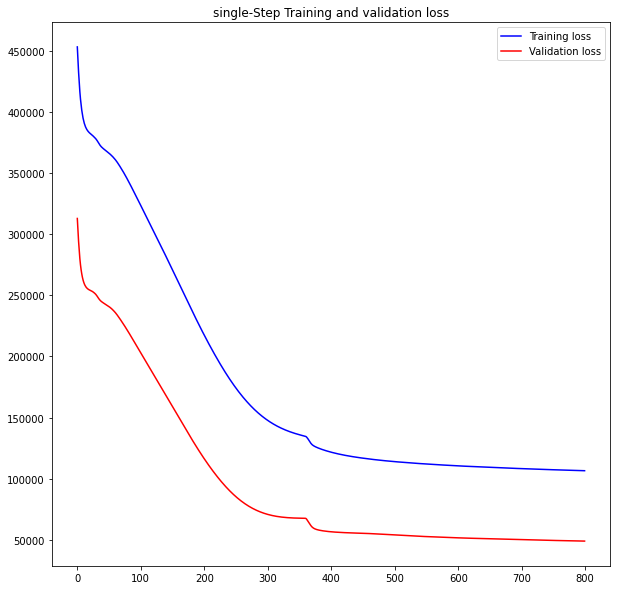

In [ ]:
plot_train_history(single_step_history, 'single-Step Training and validation loss')

[[455.2441 ]
 [441.95993]
 [464.2229 ]
 [441.6821 ]
 [448.0681 ]
 [464.65222]
 [468.8087 ]
 [462.18747]
 [446.9282 ]
 [450.66516]
 [456.1112 ]
 [459.18802]
 [456.18185]
 [441.32028]
 [439.4655 ]
 [456.67505]
 [457.20895]
 [440.54172]
 [453.5883 ]
 [452.7578 ]
 [443.68405]
 [443.78754]
 [441.78207]
 [462.46713]
 [456.2446 ]
 [458.74612]
 [449.40787]
 [449.9417 ]
 [446.02847]
 [453.2585 ]
 [455.24152]
 [455.2615 ]
 [451.91165]
 [442.01318]
 [456.19507]
 [452.84247]
 [442.31384]
 [447.13116]
 [440.55832]
 [439.3376 ]
 [442.9001 ]
 [442.96918]
 [443.9544 ]
 [444.4922 ]
 [446.16733]
 [430.3509 ]
 [449.48257]
 [431.4583 ]
 [423.33572]
 [455.71283]
 [433.34705]
 [427.18976]
 [434.00146]
 [432.12326]
 [428.48907]
 [432.34747]
 [442.47067]
 [451.55487]
 [444.5538 ]
 [436.14813]
 [416.6292 ]
 [431.24695]
 [441.64755]
 [434.88733]]
tf.Tensor(
[908. 907. 906. 905. 904. 903. 902. 901. 900. 899. 898. 897. 896. 895.
 894. 893. 892. 891. 890. 889. 888. 887. 886. 885. 884. 883. 882. 881.
 880. 879. 878

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[486.0607 ]
 [512.87726]
 [493.17377]
 [488.45087]
 [505.3648 ]
 [504.82053]
 [493.01   ]
 [488.06165]
 [483.59412]
 [485.46344]
 [496.1915 ]
 [485.79285]
 [460.7588 ]
 [469.23145]
 [478.46283]
 [484.1786 ]
 [492.2047 ]
 [495.47797]
 [484.3652 ]
 [494.13647]
 [496.4848 ]
 [511.82693]
 [480.67352]
 [495.7765 ]
 [483.38092]
 [478.47876]
 [479.6576 ]
 [480.53778]
 [458.23645]
 [450.8928 ]
 [433.75525]
 [445.88388]
 [453.8505 ]
 [457.188  ]
 [486.04877]
 [472.456  ]
 [461.91608]
 [457.0752 ]
 [455.12775]
 [450.12775]
 [444.49033]
 [448.62595]
 [460.1808 ]
 [454.61786]
 [431.65686]
 [448.65717]
 [436.88327]
 [442.98856]
 [437.52933]
 [426.38727]
 [429.20047]
 [416.76093]
 [424.00577]
 [439.0159 ]
 [451.807  ]
 [450.79697]
 [447.00174]
 [444.68146]
 [447.23596]
 [435.90134]
 [445.05615]
 [433.4225 ]
 [419.53033]
 [433.19635]]
tf.Tensor(
[155. 154. 153. 152. 151. 150. 149. 148. 147. 146. 145. 144. 143. 142.
 141. 140. 139. 138. 137. 136. 135. 134. 133. 132. 131. 130. 129. 128.
 127. 126. 125

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[563.78314]
 [563.9411 ]
 [563.98486]
 [572.8932 ]
 [569.47144]
 [567.26416]
 [561.1689 ]
 [568.146  ]
 [555.9166 ]
 [552.5534 ]
 [563.279  ]
 [574.39996]
 [570.23267]
 [573.8914 ]
 [574.3522 ]
 [559.23444]
 [573.07996]
 [572.3155 ]
 [564.0788 ]
 [567.40875]
 [567.6535 ]
 [569.60034]
 [562.5559 ]
 [570.23224]
 [564.96484]
 [570.6946 ]
 [560.4116 ]
 [567.0722 ]
 [568.03516]
 [572.7761 ]
 [554.0153 ]
 [562.3249 ]
 [566.84314]
 [552.02454]
 [553.74115]
 [553.53143]
 [554.1038 ]
 [553.918  ]
 [557.63873]
 [553.1892 ]
 [555.7535 ]
 [550.7979 ]
 [554.9617 ]
 [565.3018 ]
 [557.2812 ]
 [554.4724 ]
 [547.5996 ]
 [536.5941 ]
 [555.0315 ]
 [545.23145]
 [551.7633 ]
 [537.61316]
 [534.09753]
 [540.7927 ]
 [549.56256]
 [540.5087 ]
 [527.6863 ]
 [521.677  ]
 [527.19543]
 [536.80927]
 [529.95807]
 [519.15497]
 [519.6551 ]
 [522.1559 ]]
tf.Tensor(
[525. 524. 523. 522. 521. 520. 519. 518. 517. 516. 515. 514. 513. 512.
 511. 510. 509. 508. 507. 506. 505. 504. 503. 502. 501. 500. 499. 498.
 497. 496. 495

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[445.82947]
 [442.6069 ]
 [442.24982]
 [444.26547]
 [460.146  ]
 [472.0721 ]
 [446.13904]
 [442.5994 ]
 [446.62024]
 [436.0661 ]
 [443.1058 ]
 [456.2154 ]
 [463.02545]
 [455.25604]
 [441.4663 ]
 [456.641  ]
 [449.3369 ]
 [442.67188]
 [452.10706]
 [459.5365 ]
 [458.39435]
 [431.21918]
 [449.2207 ]
 [433.12112]
 [442.84747]
 [454.67636]
 [432.73666]
 [441.3724 ]
 [431.10028]
 [433.7239 ]
 [434.28796]
 [429.82593]
 [442.68103]
 [436.49417]
 [450.08444]
 [440.45795]
 [430.11255]
 [453.86093]
 [449.74606]
 [435.44626]
 [441.578  ]
 [442.8023 ]
 [431.04266]
 [419.4608 ]
 [407.88055]
 [416.01007]
 [413.59314]
 [424.71518]
 [415.48578]
 [442.64032]
 [432.6397 ]
 [428.65625]
 [418.60526]
 [431.6036 ]
 [417.87665]
 [421.23474]
 [417.73822]
 [404.12866]
 [425.60846]
 [425.25336]
 [417.62534]
 [421.6175 ]
 [404.25073]
 [407.97812]]
tf.Tensor(
[141. 140. 139. 138. 137. 136. 135. 134. 133. 132. 131. 130. 129. 128.
 127. 126. 125. 124. 123. 122. 121. 120. 119. 118. 117. 116. 115. 114.
 113. 112. 111

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[565.44574]
 [567.0135 ]
 [565.8858 ]
 [563.2245 ]
 [565.9536 ]
 [558.9743 ]
 [554.58624]
 [567.70416]
 [565.7956 ]
 [558.2203 ]
 [557.94604]
 [563.47845]
 [558.1219 ]
 [550.6582 ]
 [548.11176]
 [563.24835]
 [557.2924 ]
 [545.73596]
 [540.8764 ]
 [545.9326 ]
 [550.41956]
 [556.73376]
 [551.728  ]
 [552.18585]
 [554.52325]
 [557.1923 ]
 [558.85284]
 [551.67487]
 [556.1487 ]
 [555.5031 ]
 [542.6442 ]
 [547.41846]
 [545.03796]
 [536.9756 ]
 [543.5713 ]
 [543.1288 ]
 [540.7992 ]
 [543.1459 ]
 [536.8108 ]
 [535.5028 ]
 [537.55695]
 [539.10925]
 [523.1708 ]
 [523.7437 ]
 [534.5283 ]
 [523.5171 ]
 [526.0278 ]
 [529.9254 ]
 [515.5277 ]
 [513.2481 ]
 [514.5889 ]
 [525.2212 ]
 [509.11258]
 [510.4927 ]
 [526.6223 ]
 [520.88116]
 [525.62555]
 [539.6966 ]
 [525.1019 ]
 [537.66547]
 [529.0824 ]
 [528.4424 ]
 [531.85046]
 [542.1731 ]]
tf.Tensor(
[633. 632. 631. 630. 629. 628. 627. 626. 625. 624. 623. 622. 621. 620.
 619. 618. 617. 616. 615. 614. 613. 612. 611. 610. 609. 608. 607. 606.
 605. 604. 603

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[452.83487]
 [459.17856]
 [446.74963]
 [456.56927]
 [471.87573]
 [454.29407]
 [447.8587 ]
 [444.71255]
 [441.84085]
 [439.55273]
 [454.12244]
 [467.00055]
 [451.9333 ]
 [431.21417]
 [446.62946]
 [445.68475]
 [447.5879 ]
 [434.4579 ]
 [449.7032 ]
 [454.50717]
 [458.24017]
 [447.5413 ]
 [463.47424]
 [446.26166]
 [449.6039 ]
 [446.41348]
 [438.4685 ]
 [440.36584]
 [435.3487 ]
 [430.65753]
 [425.56042]
 [420.4606 ]
 [437.48514]
 [428.64365]
 [433.7724 ]
 [448.26746]
 [435.46262]
 [416.91125]
 [416.00293]
 [435.4674 ]
 [433.1154 ]
 [422.28836]
 [426.23386]
 [409.71832]
 [420.18732]
 [402.84174]
 [414.00702]
 [424.10056]
 [409.6606 ]
 [404.567  ]
 [406.37115]
 [409.68506]
 [397.701  ]
 [405.4254 ]
 [415.20877]
 [410.4449 ]
 [408.208  ]
 [406.52307]
 [395.6432 ]
 [396.74863]
 [388.0952 ]
 [413.30933]
 [402.83517]
 [398.42404]]
tf.Tensor(
[249. 248. 247. 246. 245. 244. 243. 242. 241. 240. 239. 238. 237. 236.
 235. 234. 233. 232. 231. 230. 229. 228. 227. 226. 225. 224. 223. 222.
 221. 220. 219

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[610.24603]
 [612.3997 ]
 [610.391  ]
 [611.4605 ]
 [611.8063 ]
 [612.0546 ]
 [613.73676]
 [613.6775 ]
 [614.49097]
 [611.38586]
 [612.87384]
 [612.87756]
 [609.84644]
 [611.59406]
 [612.096  ]
 [613.89886]
 [613.83673]
 [611.87463]
 [612.5022 ]
 [606.4067 ]
 [609.37634]
 [610.81256]
 [609.8897 ]
 [608.3382 ]
 [608.5431 ]
 [607.3782 ]
 [609.8482 ]
 [610.8148 ]
 [609.70355]
 [610.8422 ]
 [611.0103 ]
 [609.2876 ]
 [608.74286]
 [609.0118 ]
 [610.20465]
 [610.5244 ]
 [610.1573 ]
 [610.98846]
 [610.4659 ]
 [611.32526]
 [609.1649 ]
 [609.43805]
 [610.4737 ]
 [610.43823]
 [609.1455 ]
 [607.6042 ]
 [606.5135 ]
 [608.96216]
 [606.62524]
 [607.20056]
 [609.45605]
 [607.52875]
 [609.164  ]
 [609.6605 ]
 [607.2224 ]
 [605.8774 ]
 [606.2435 ]
 [596.66296]
 [605.67096]
 [593.96075]
 [595.8719 ]
 [607.29095]
 [605.23816]
 [607.74634]]
tf.Tensor(
[774. 773. 772. 771. 770. 769. 768. 767. 766. 765. 764. 763. 762. 761.
 760. 759. 758. 757. 756. 755. 754. 753. 752. 751. 750. 749. 748. 747.
 746. 745. 744

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[517.4063 ]
 [519.4111 ]
 [507.81277]
 [504.47662]
 [506.079  ]
 [519.3036 ]
 [517.0594 ]
 [507.7929 ]
 [508.265  ]
 [498.71896]
 [504.9786 ]
 [512.2034 ]
 [505.86755]
 [502.25998]
 [489.55496]
 [481.5786 ]
 [490.05862]
 [493.2786 ]
 [490.20248]
 [480.57568]
 [475.27197]
 [466.77484]
 [471.8059 ]
 [472.26993]
 [467.0744 ]
 [458.4278 ]
 [477.68826]
 [472.83875]
 [469.15643]
 [479.00412]
 [471.84247]
 [468.63278]
 [479.75317]
 [479.61856]
 [489.59525]
 [485.14465]
 [481.111  ]
 [486.0291 ]
 [478.5662 ]
 [491.39642]
 [483.68097]
 [466.86374]
 [472.3034 ]
 [468.50455]
 [472.3161 ]
 [476.60687]
 [481.78867]
 [480.83255]
 [481.30463]
 [463.7346 ]
 [493.09177]
 [477.51096]
 [481.75214]
 [487.39178]
 [460.29028]
 [469.39752]
 [476.98553]
 [474.15588]
 [465.73264]
 [469.54086]
 [451.37372]
 [481.68445]
 [473.92953]
 [483.54712]]
tf.Tensor(
[390. 389. 388. 387. 386. 385. 384. 383. 382. 381. 380. 379. 378. 377.
 376. 375. 374. 373. 372. 371. 370. 369. 368. 367. 366. 365. 364. 363.
 362. 361. 360

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

[[345.081  ]
 [349.10394]
 [357.97827]
 [346.729  ]
 [330.73904]
 [346.04926]
 [373.5181 ]
 [363.62854]
 [377.69885]
 [398.8525 ]
 [406.79553]
 [403.6745 ]
 [395.9203 ]]
tf.Tensor([  6.   5.   4.   3.   2.   1.   0. 720. 719. 718. 717. 716. 715.], shape=(13,), dtype=float32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


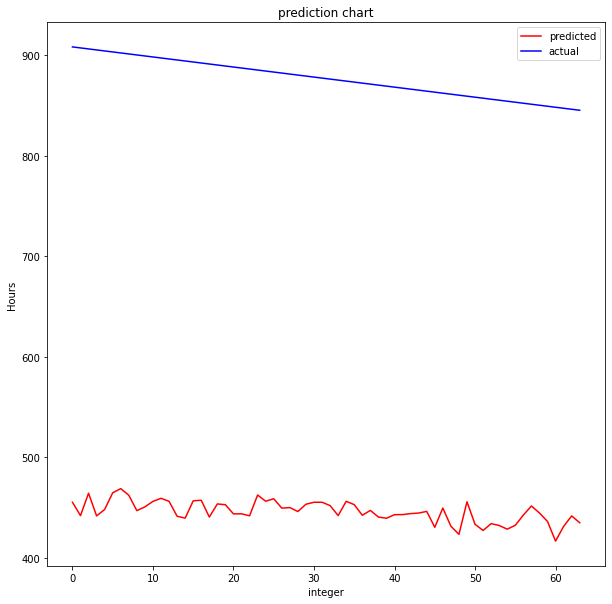

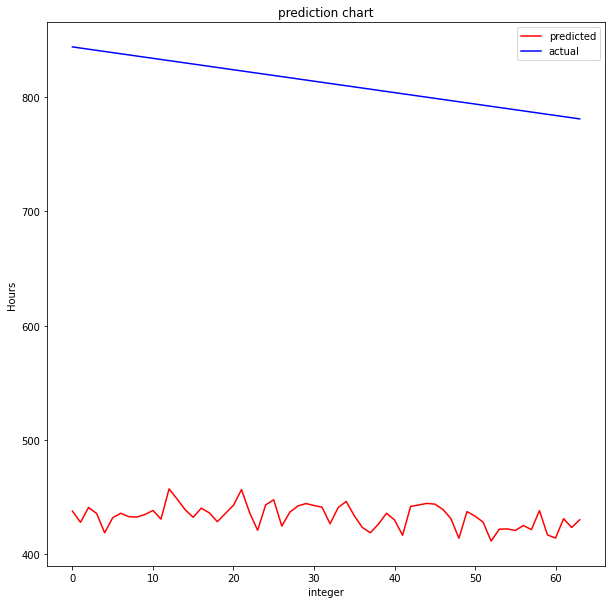

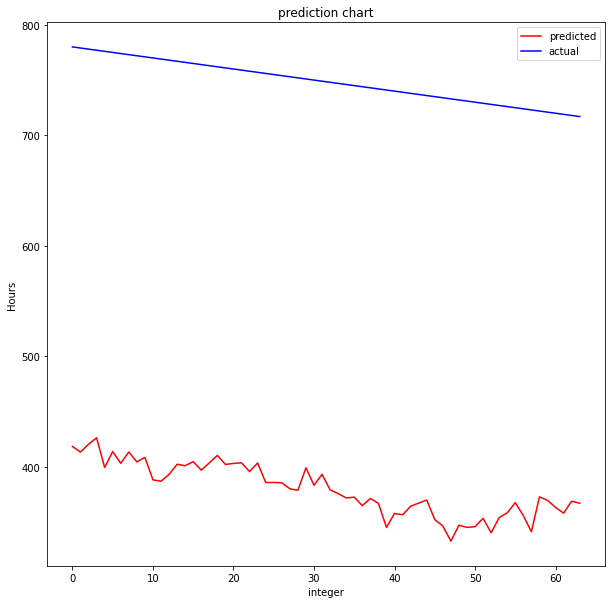

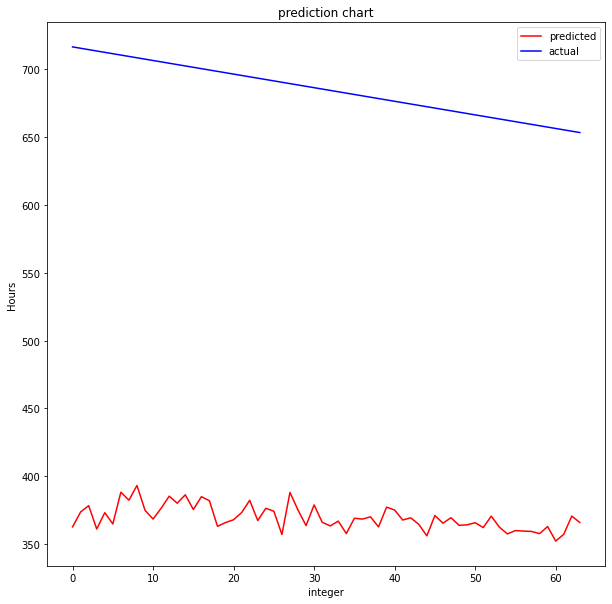

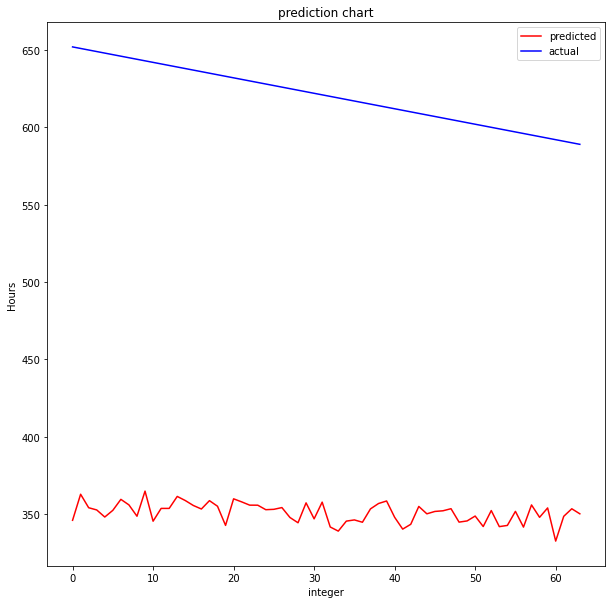

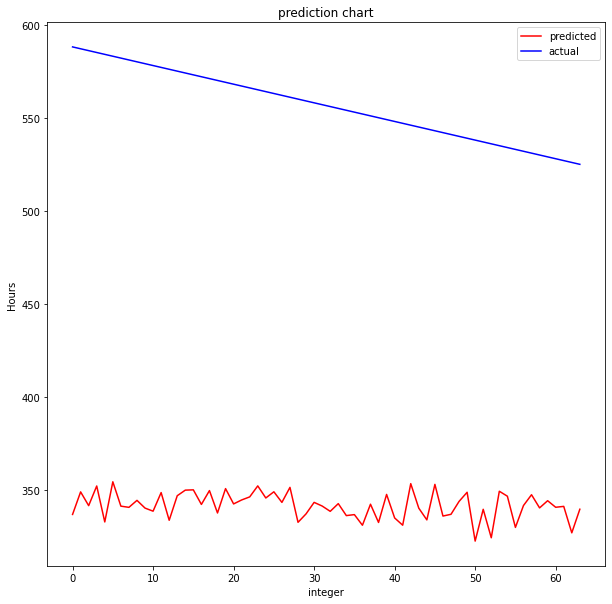

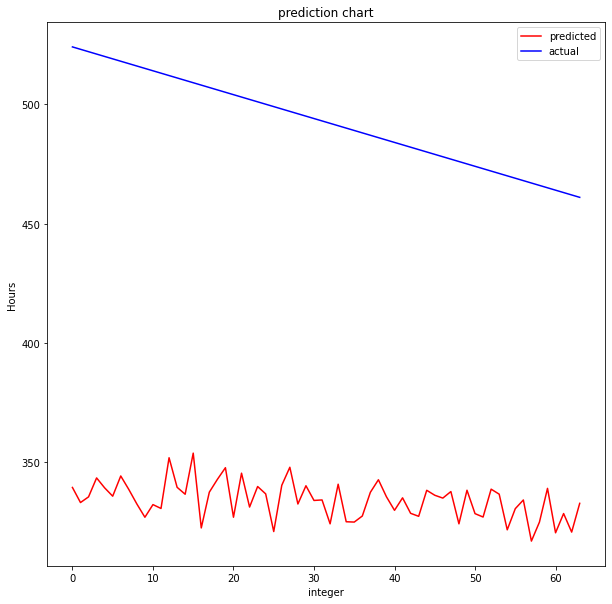

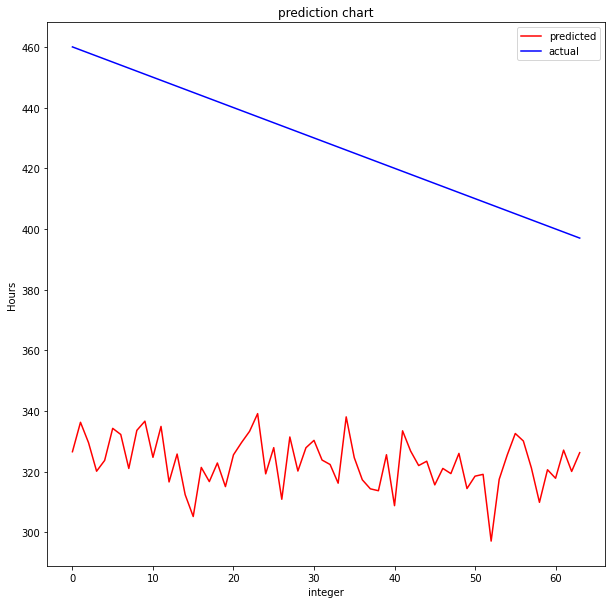

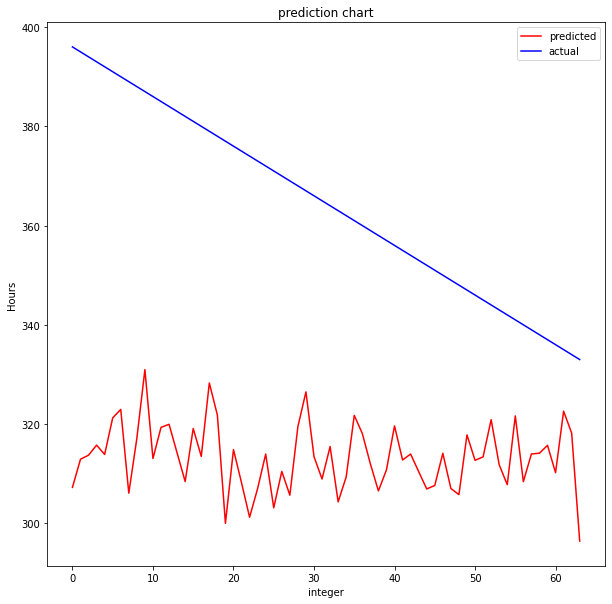

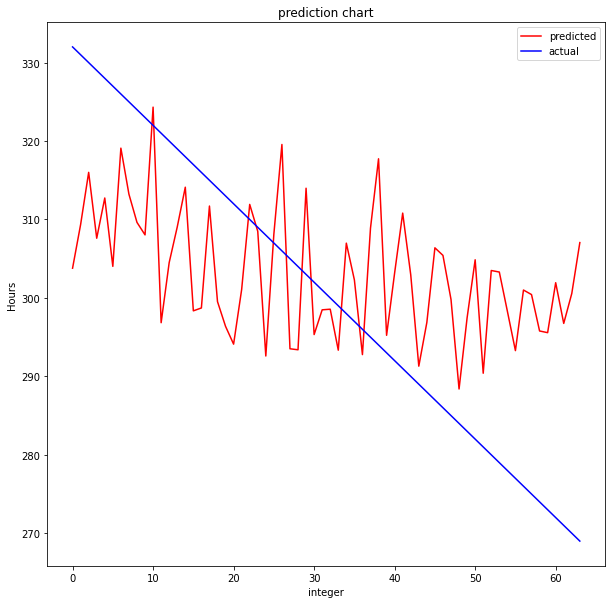

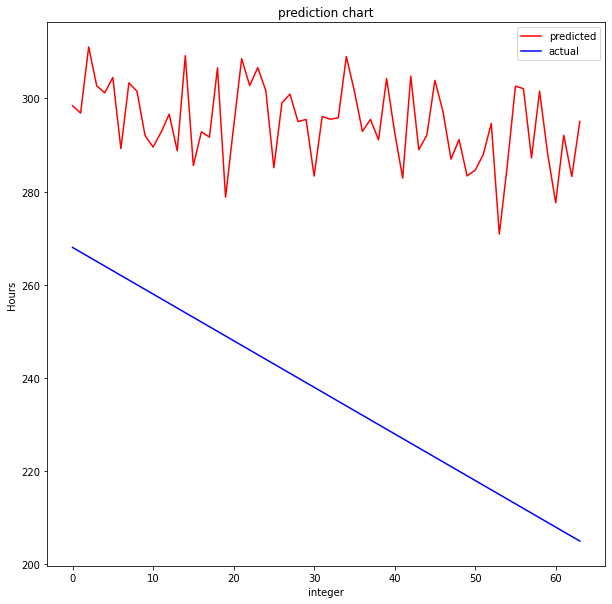

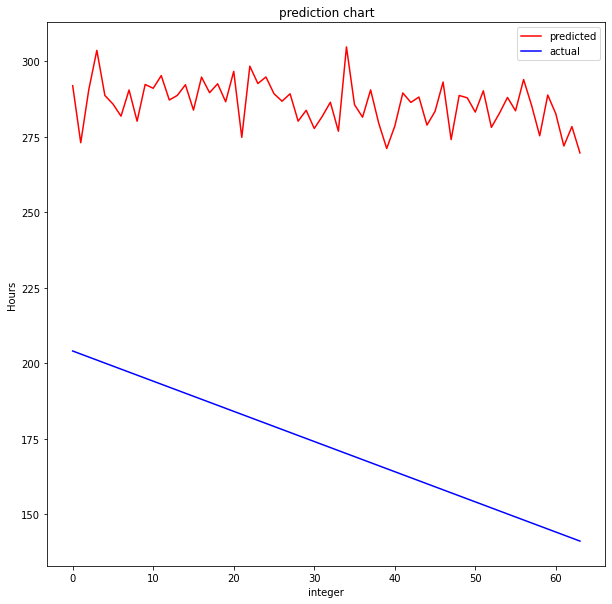

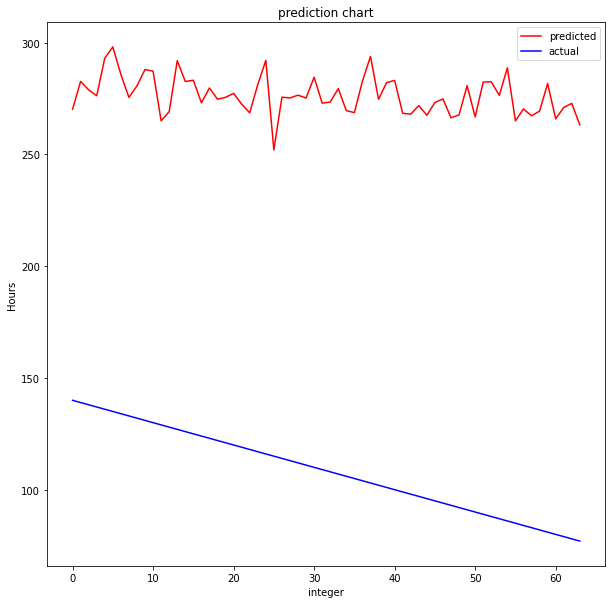

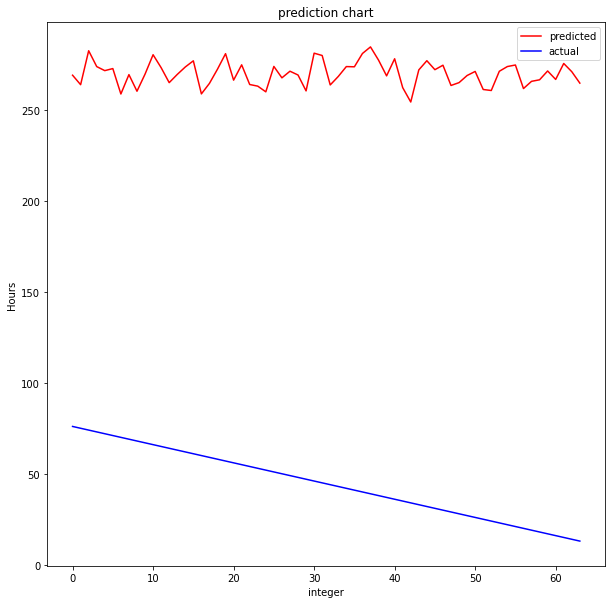

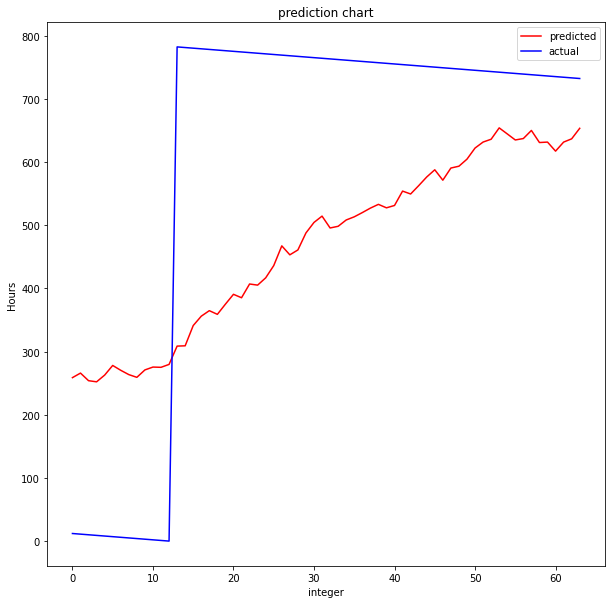

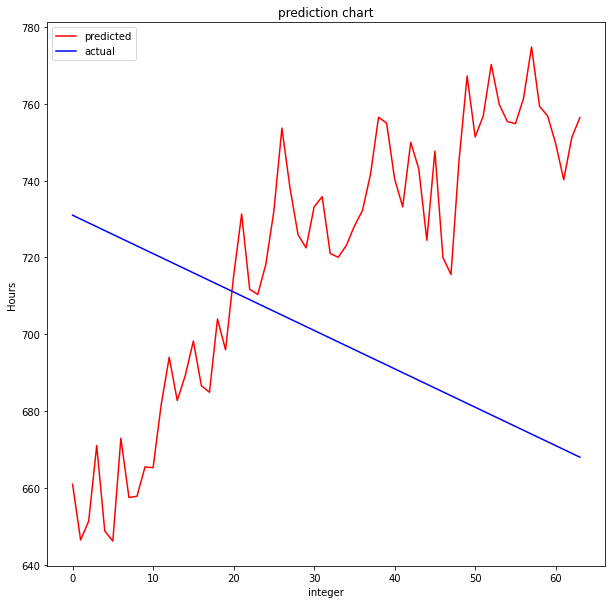

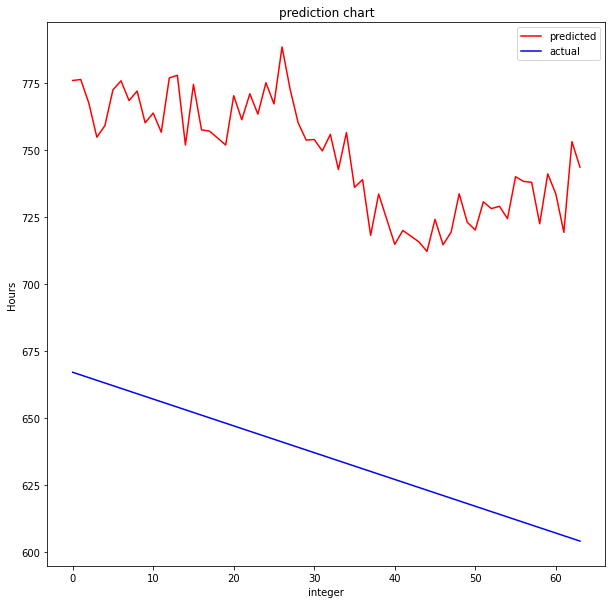

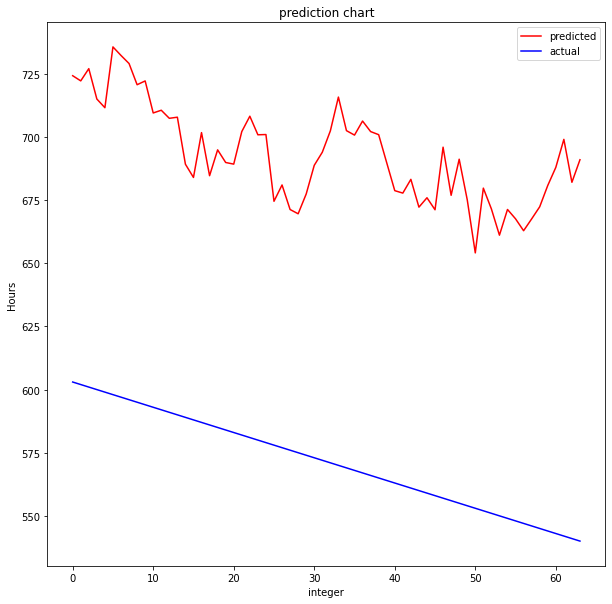

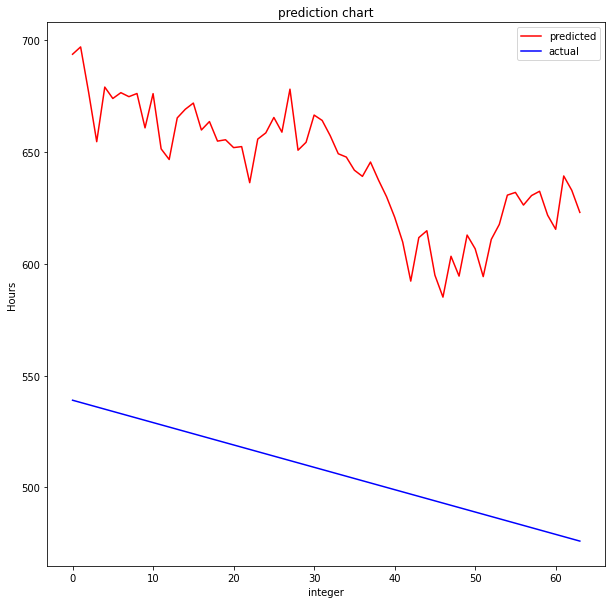

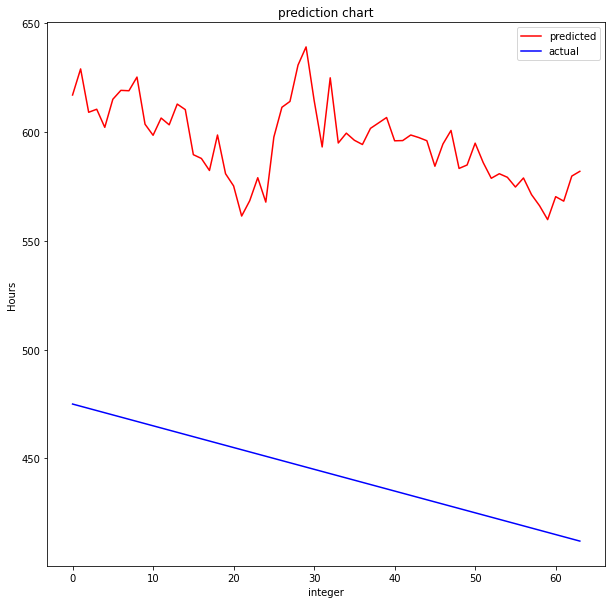

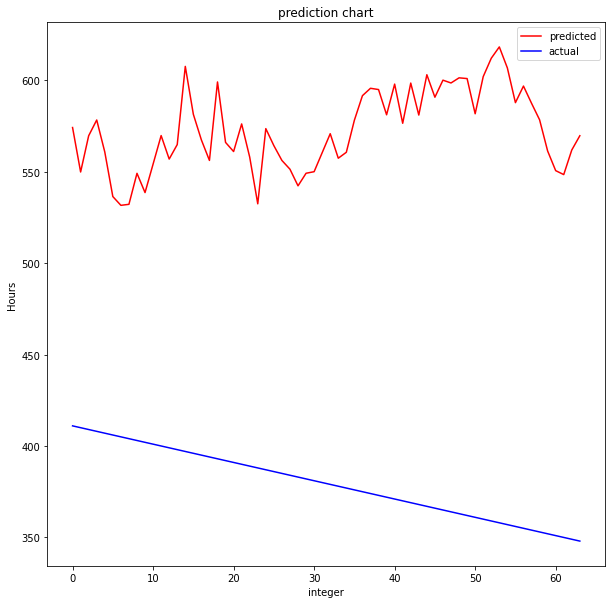

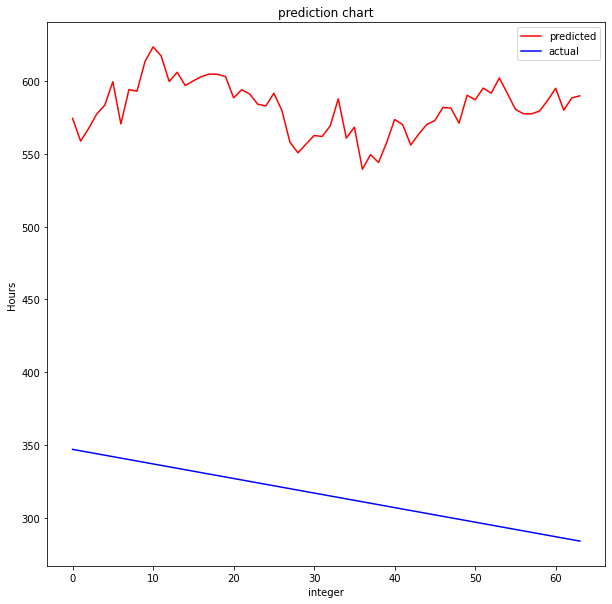

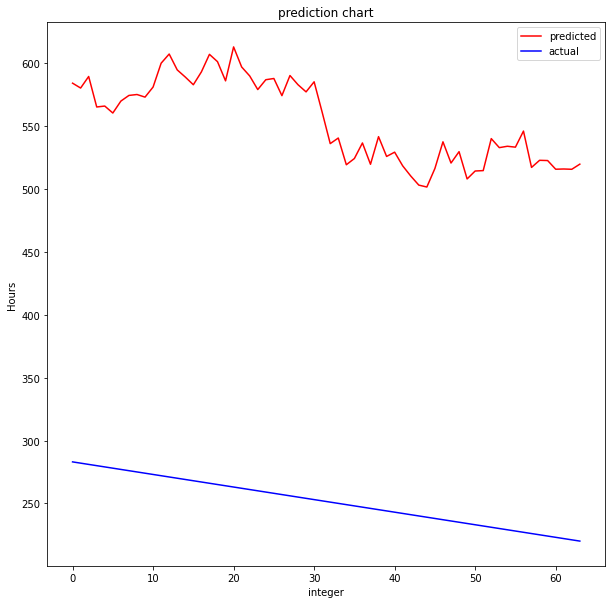

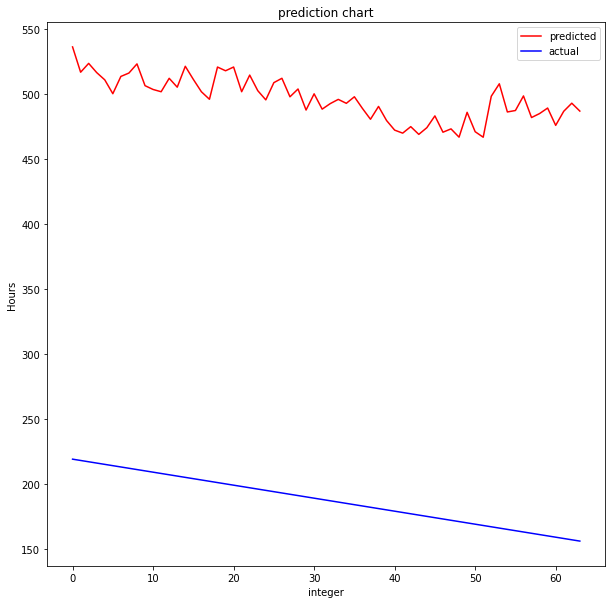

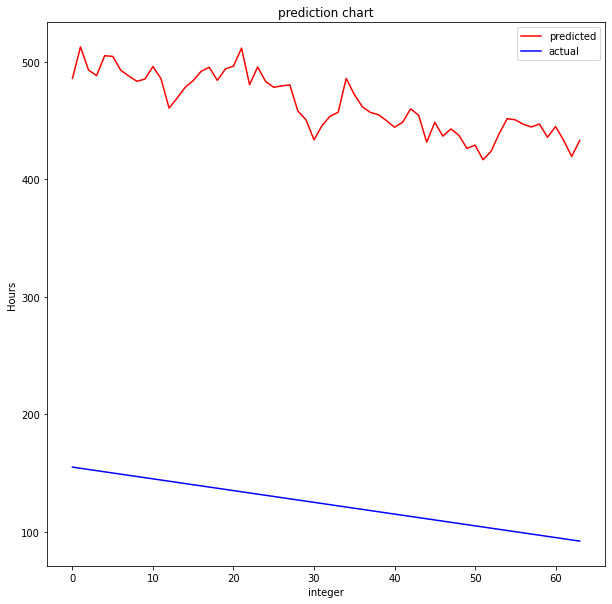

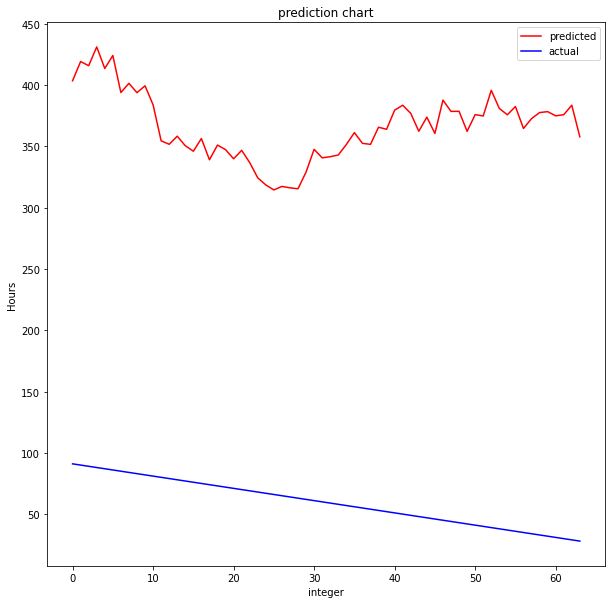

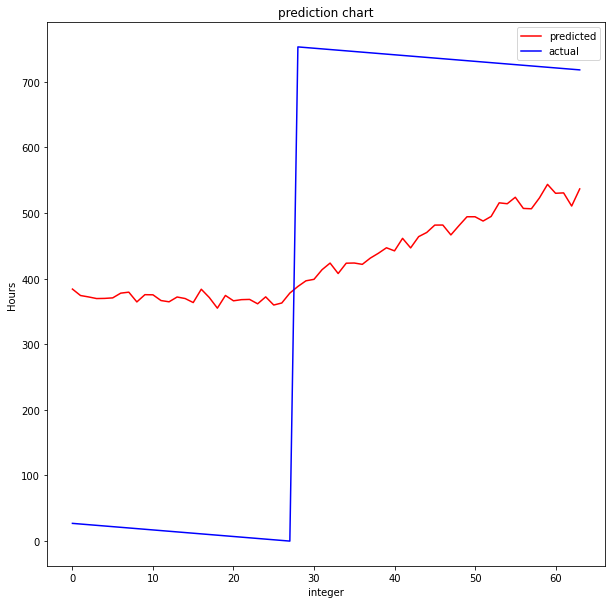

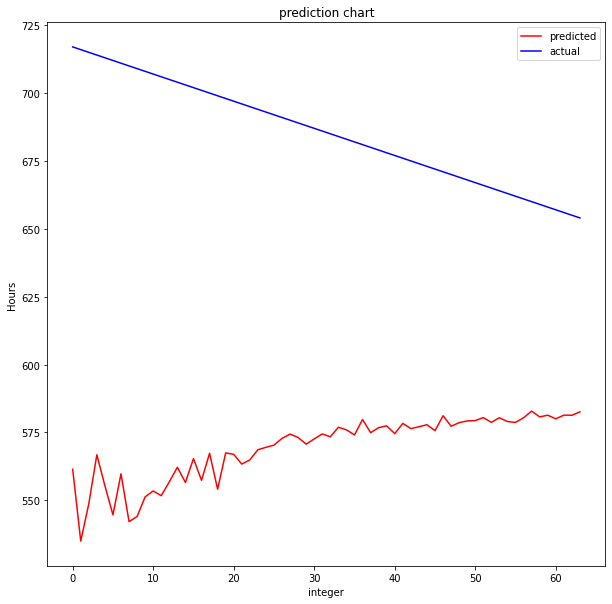

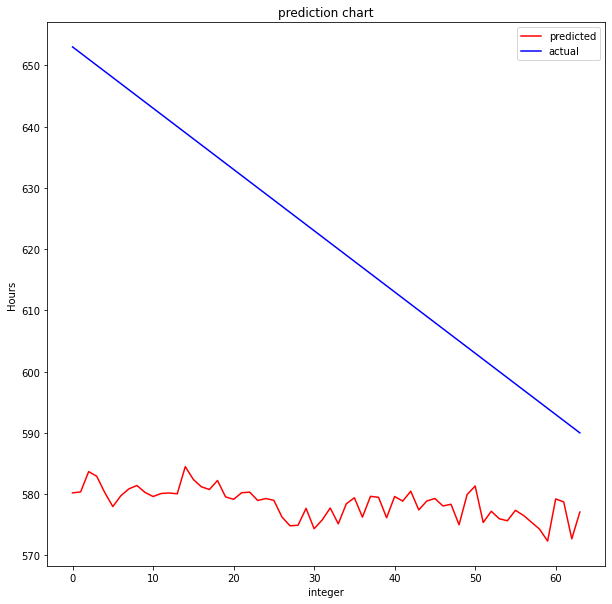

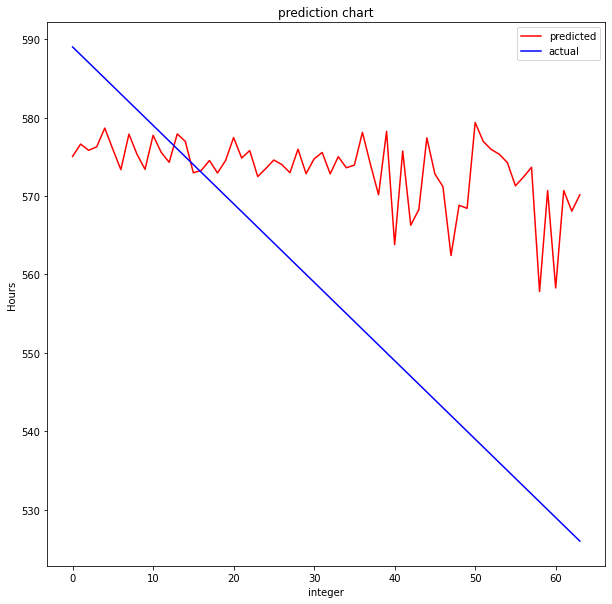

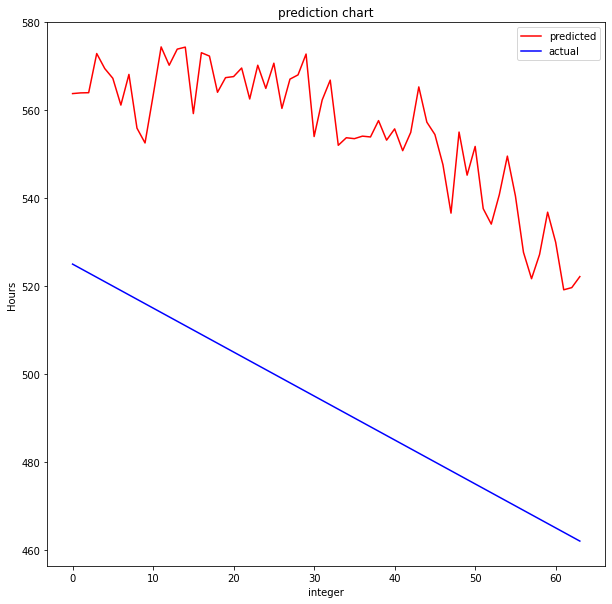

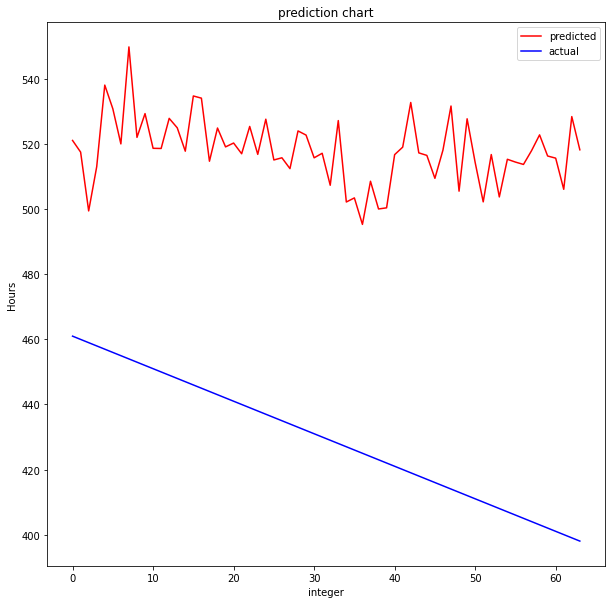

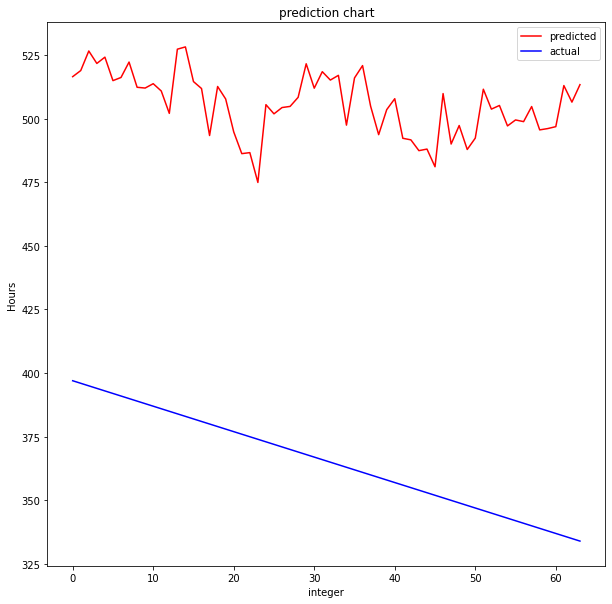

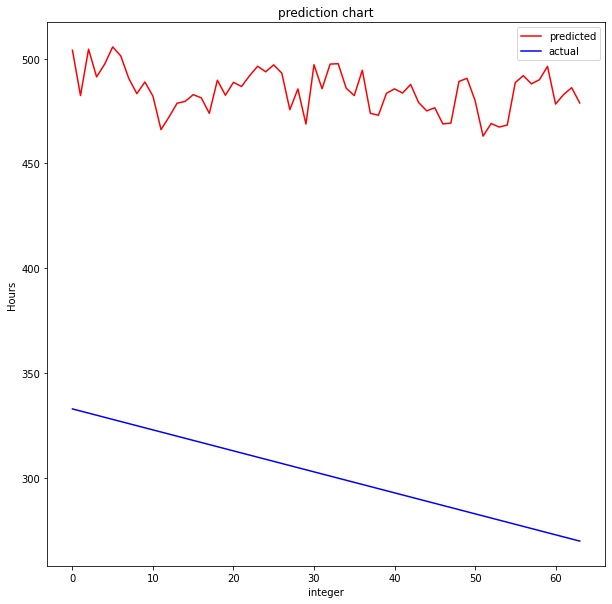

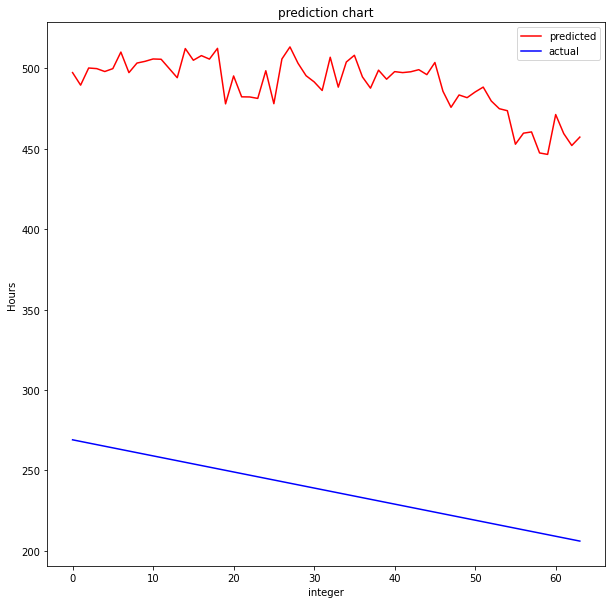

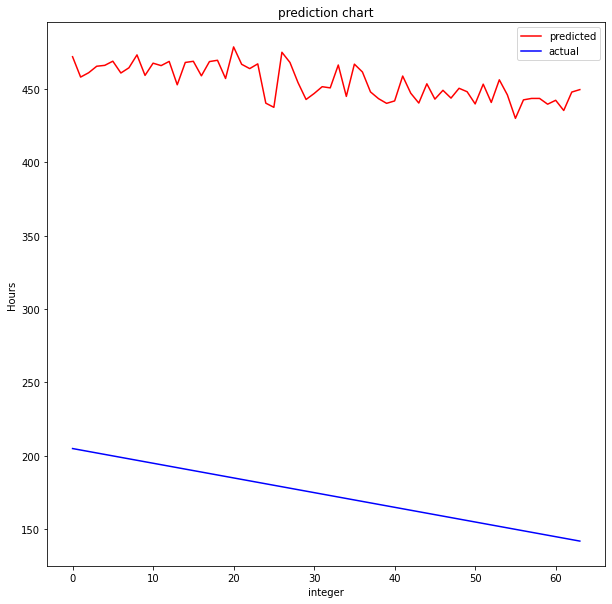

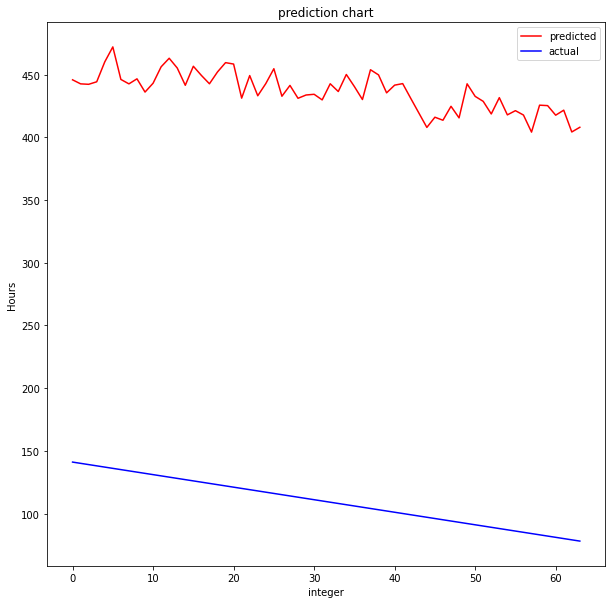

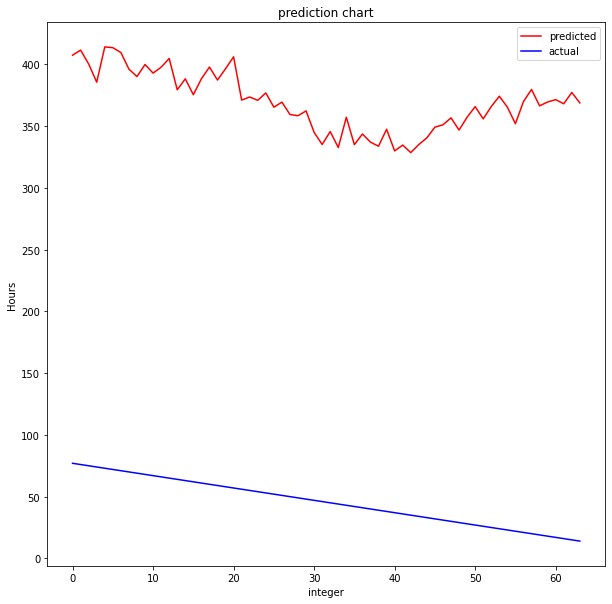

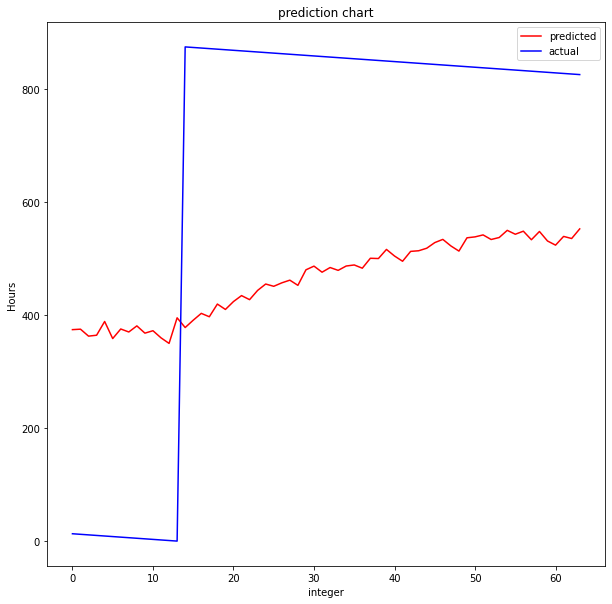

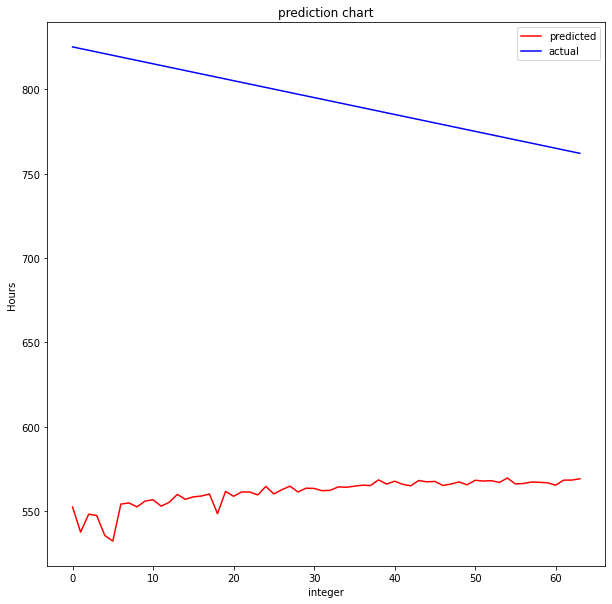

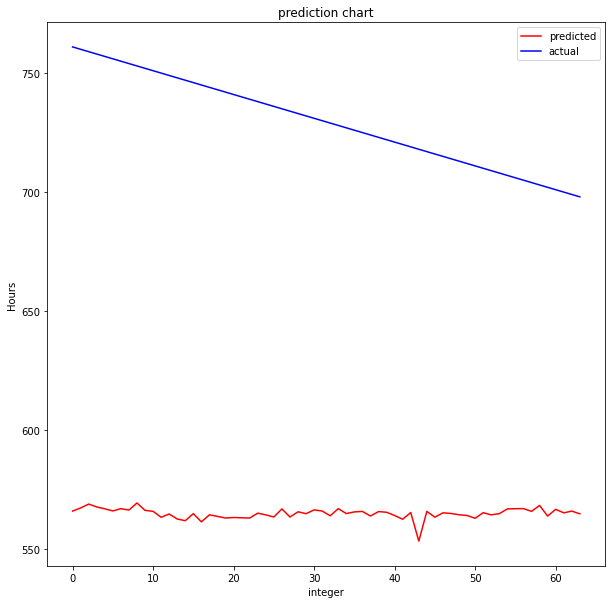

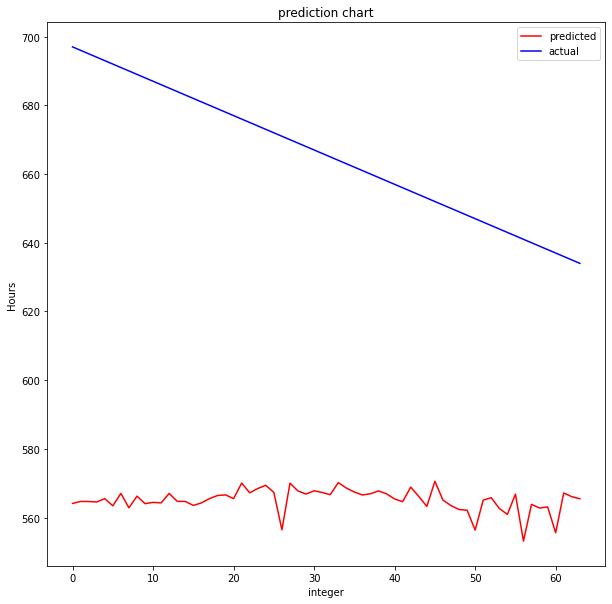

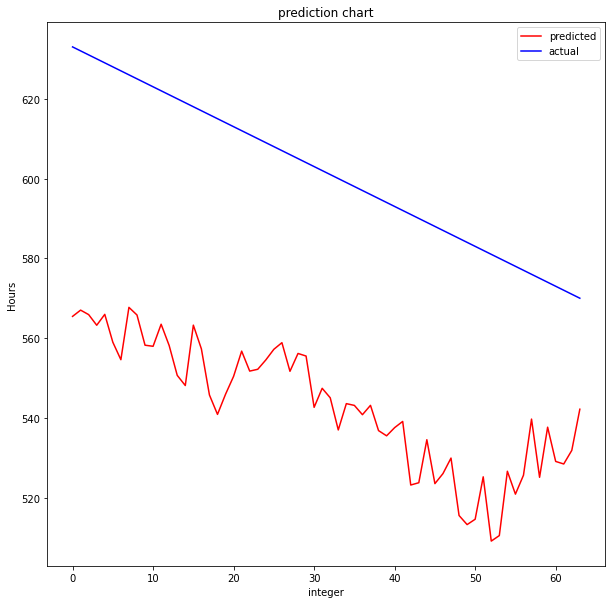

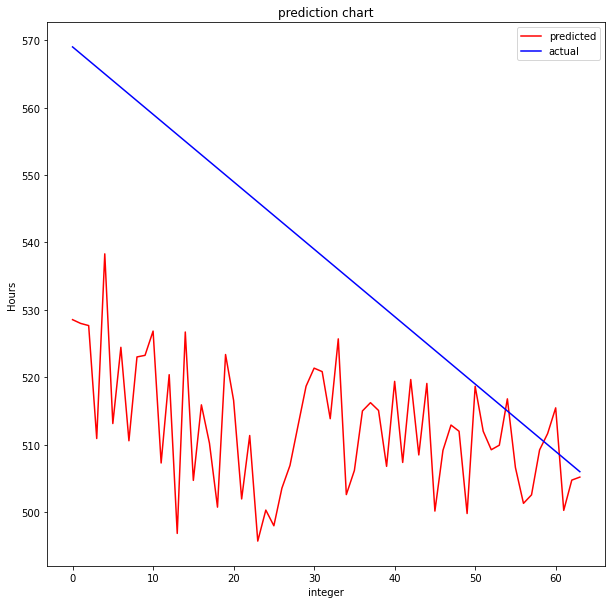

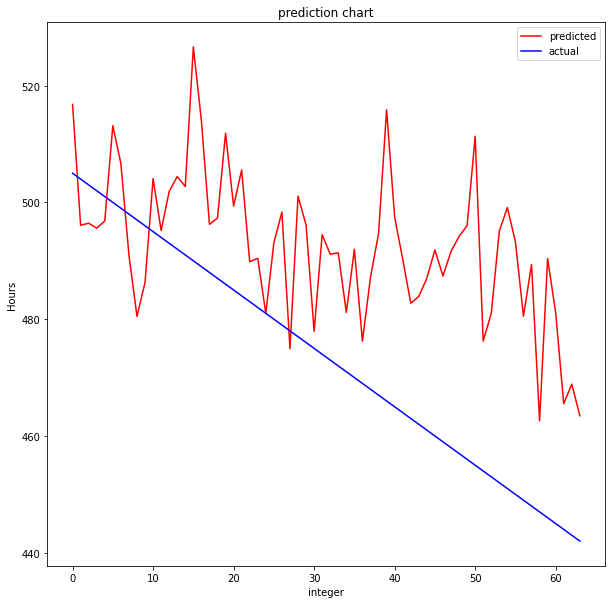

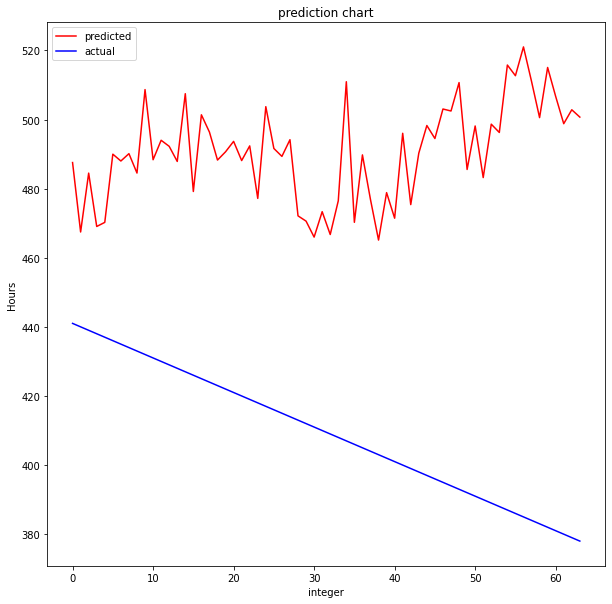

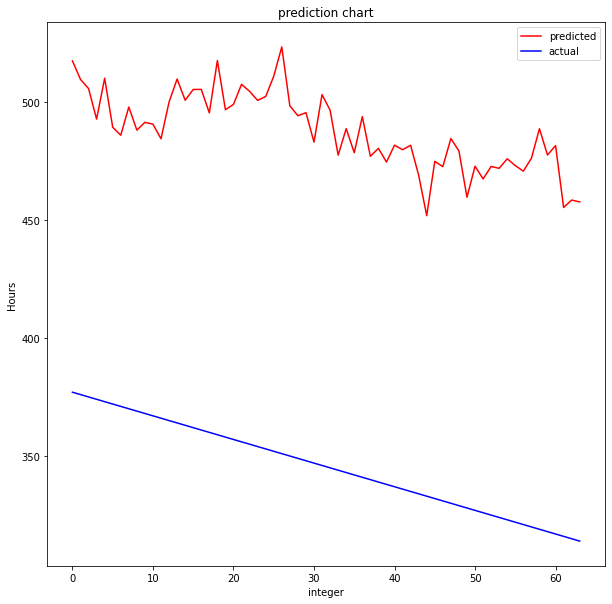

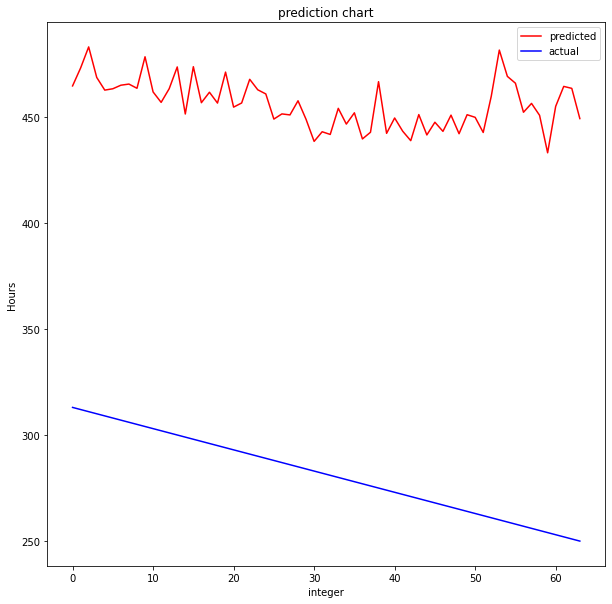

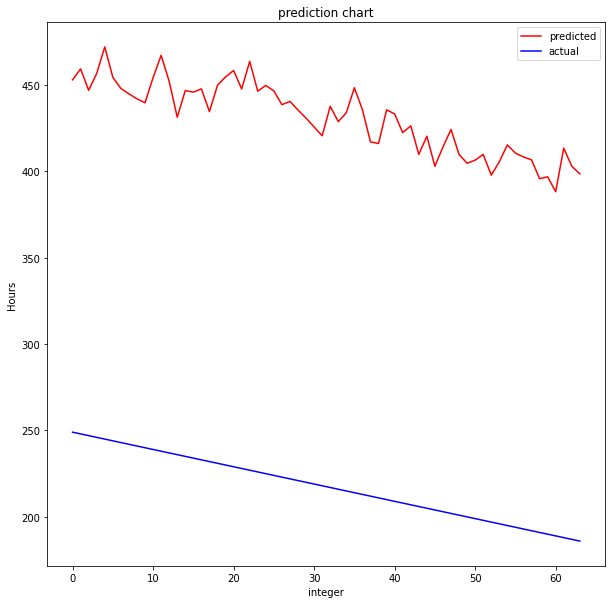

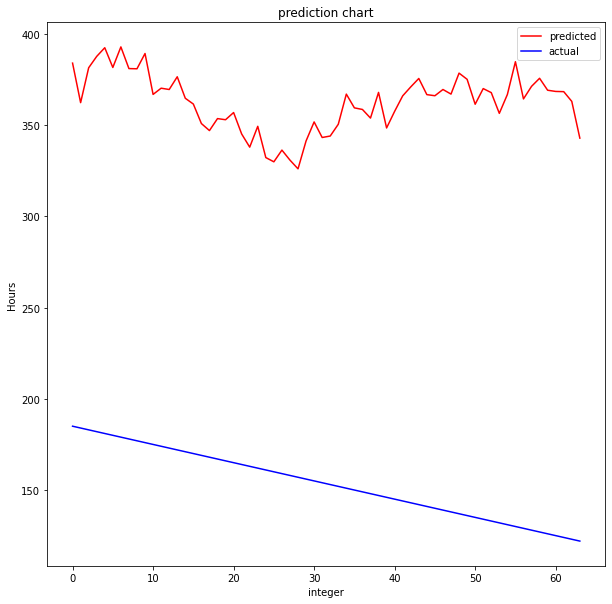

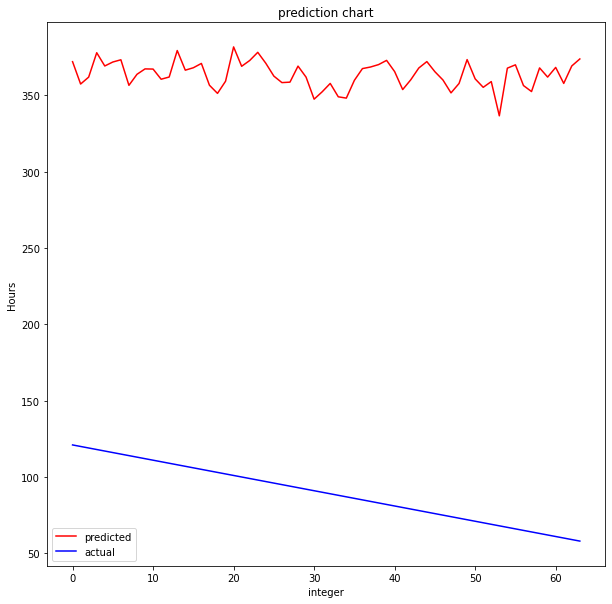

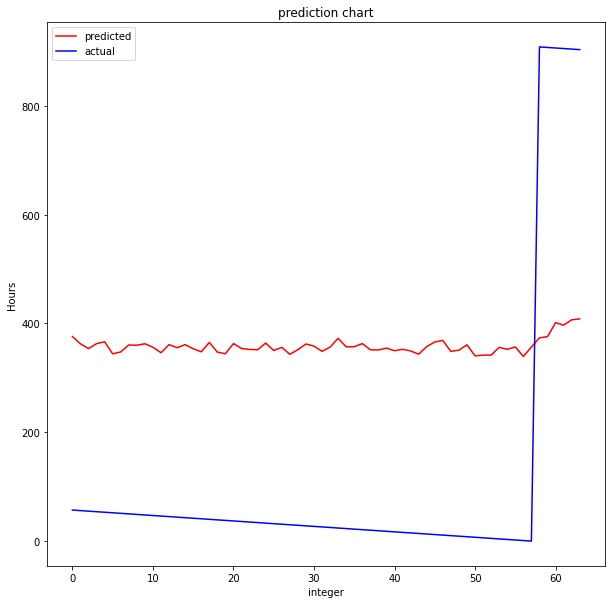

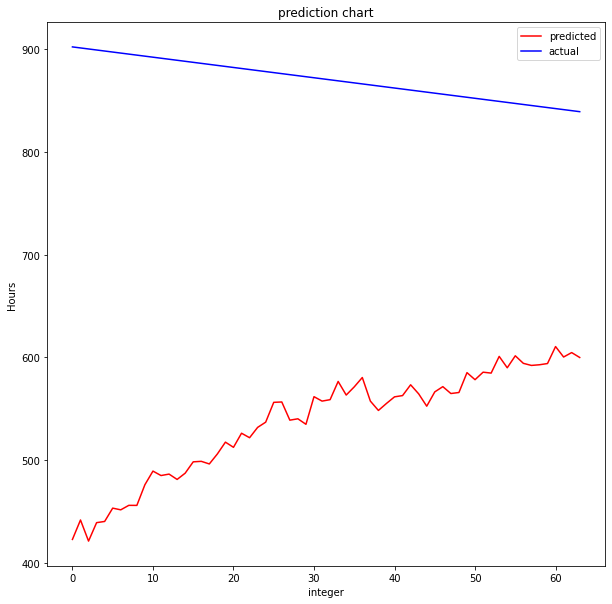

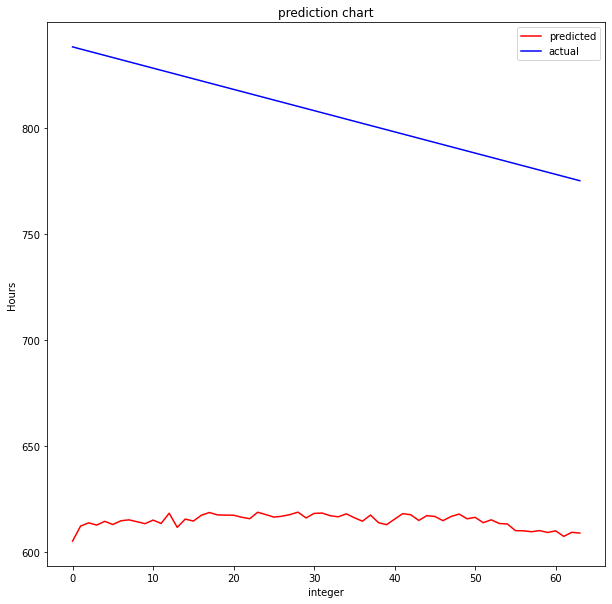

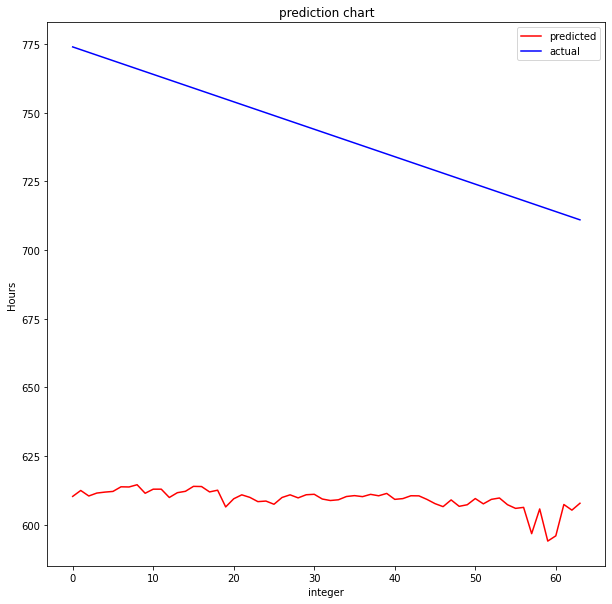

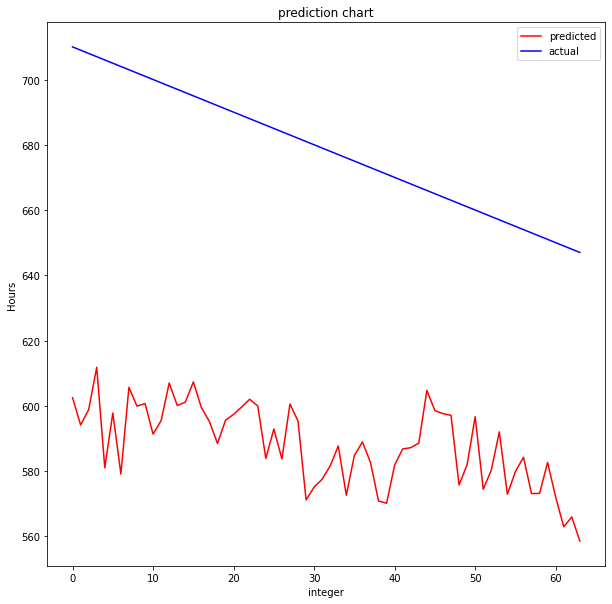

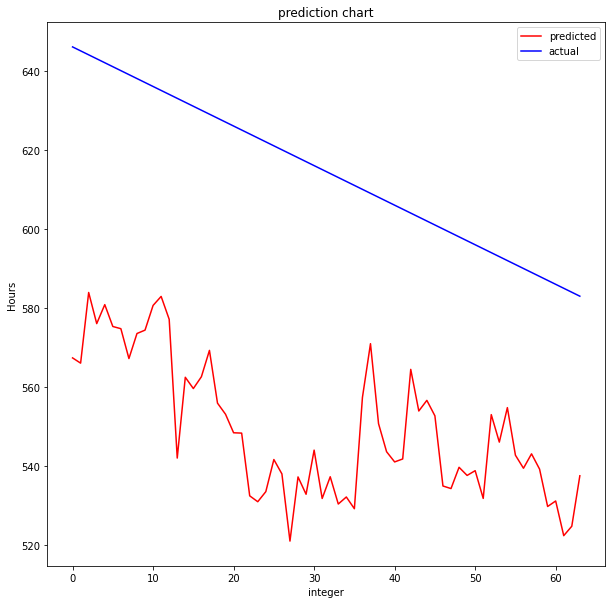

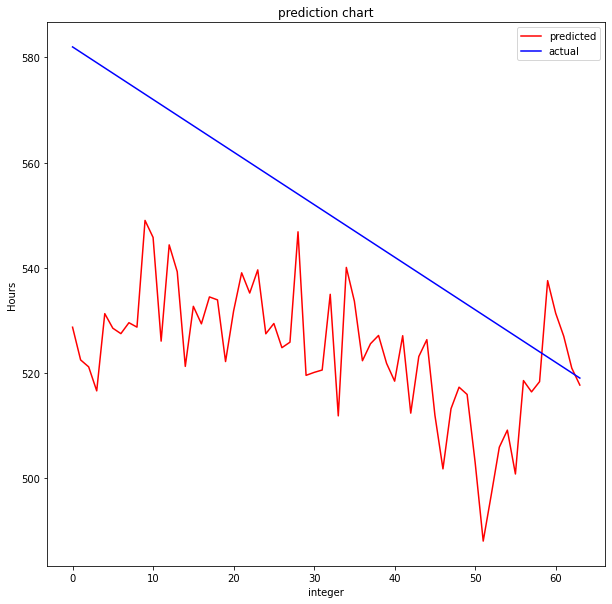

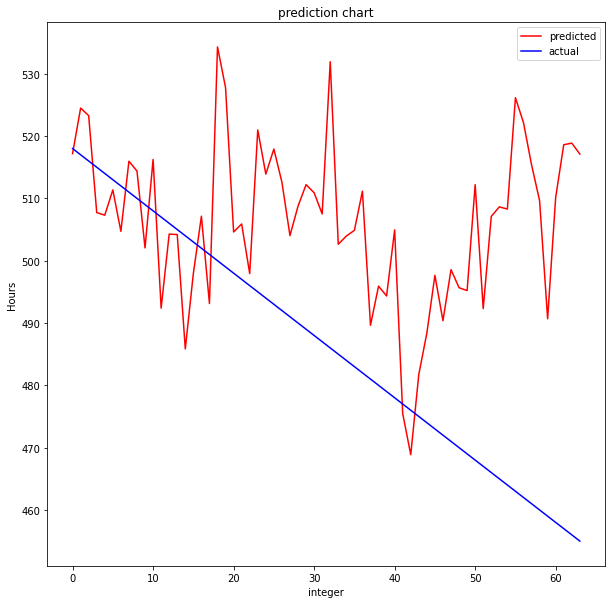

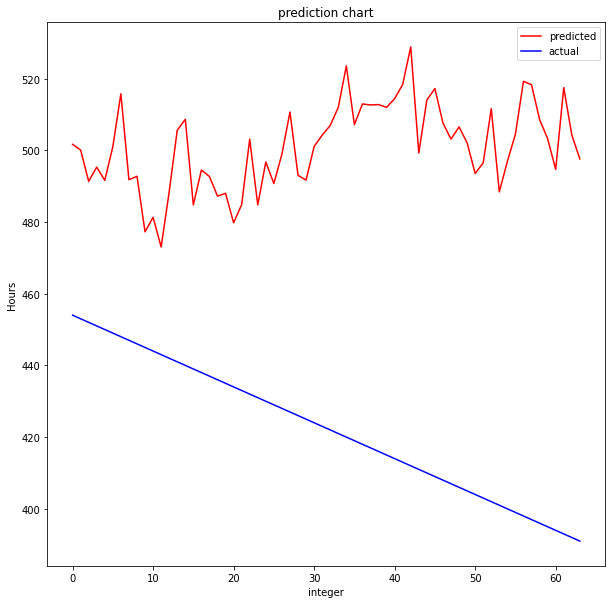

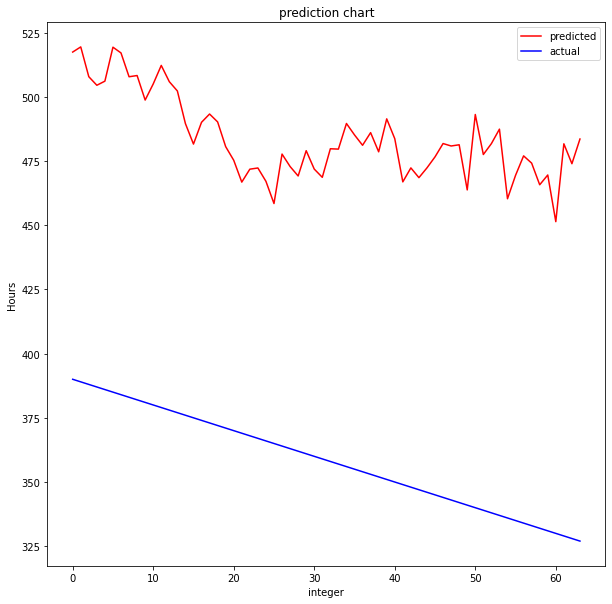

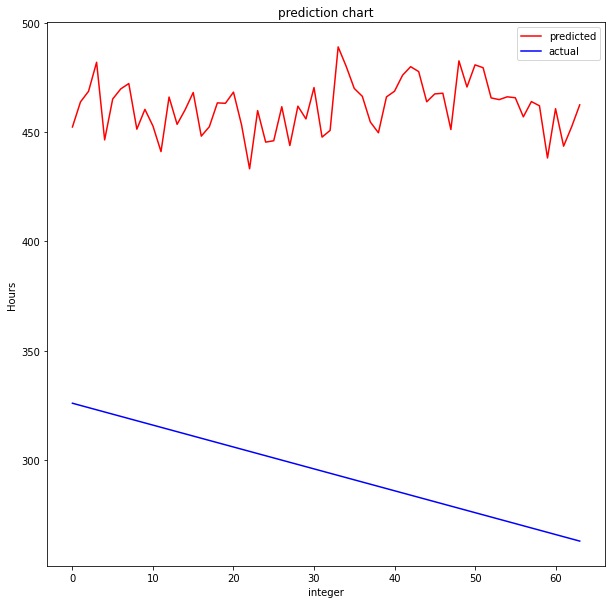

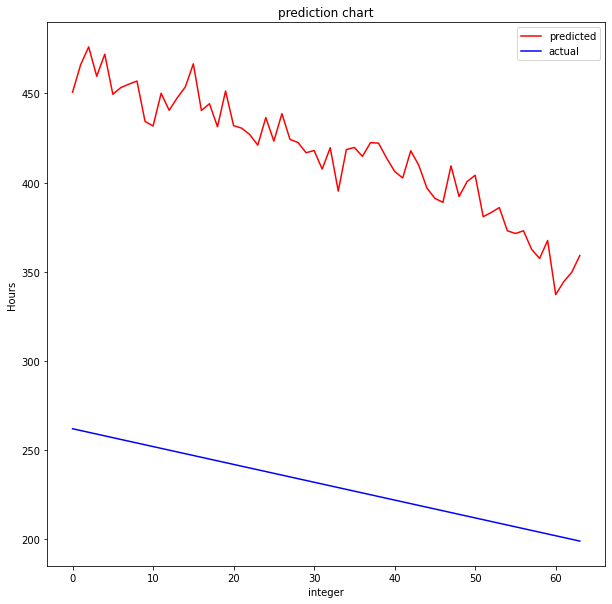

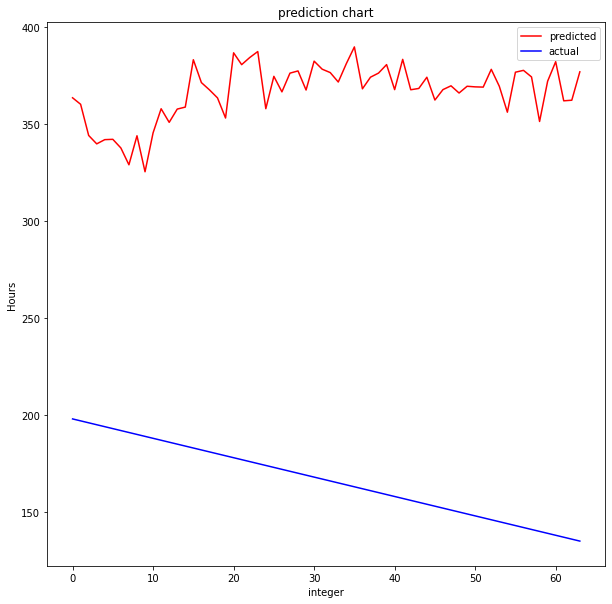

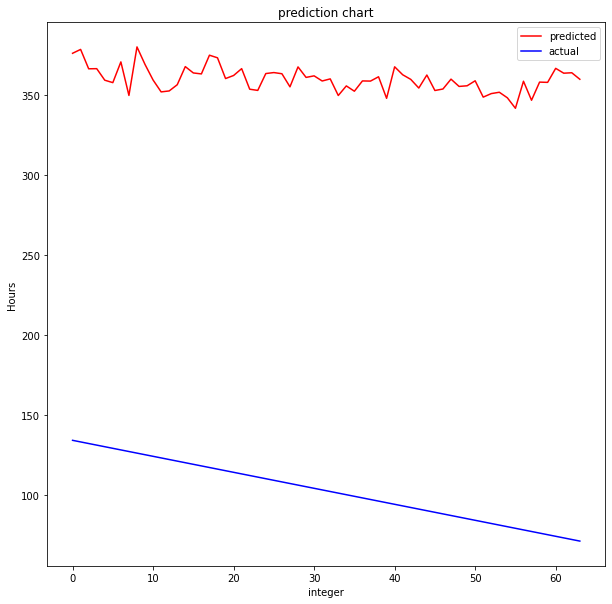

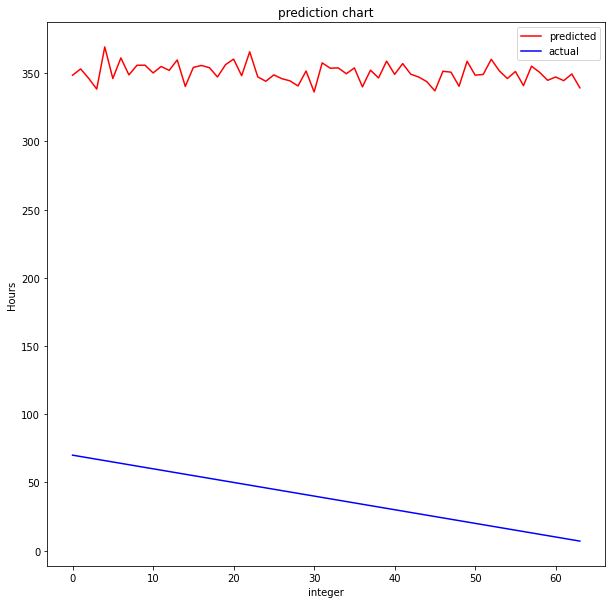

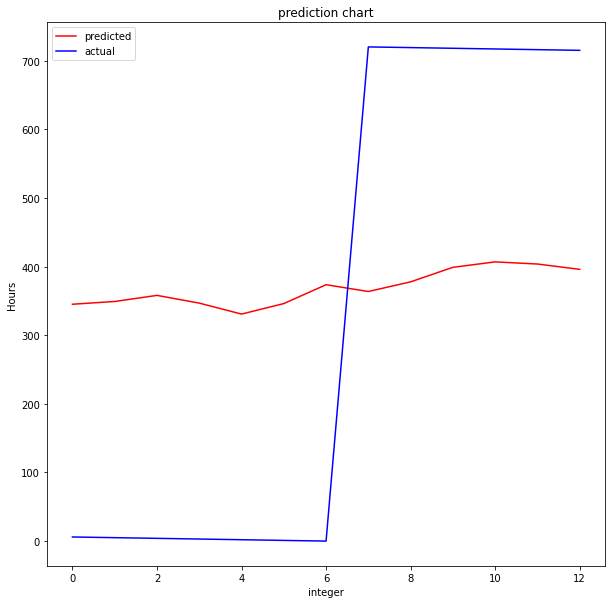

In [ ]:
y1 = None
y0=None
y=None
for x, y in val_data_single.take(100):
  if y1 != None:
    y0 = single_step_model.predict(x)
    print(y0)
    print(y)
    y_1 = y.numpy()
    #plt.rcParams["figure.figsize"] = (10, 10)

# create the plot space upon which to plot the data
    fig, ax = plt.subplots()

# add the x-axis and the y-axis to the plot
    ax.plot(np.arange(len(y_1)), y0, color="red")
    ax.plot(np.arange(len(y_1)), y, color="blue")
    ax.legend(['predicted','actual'])
# set plot title
    ax.set(title="prediction chart")

# add labels to the axes
    ax.set(xlabel="integer", ylabel="Hours");
    #z = [y1.numpy(), y[BUFFER_SIZE-1].numpy(), y0]
    #show_plot(z, 0, 'Prediction')
  y1 = y